# Experiments for the Bachelor's Program in Business Informatics University of Mannheim
This notebook contains the experiments performed on the Course-Skill Graph and Two-Step Course Recommendation Algorithm for the Bachelor's Program in Business Informatics at the University of Mannheim.

The notebook is divided into the following sections:
1. Imports
2. Experiments

## 1. Imports

In [2]:
import camelot
import pandas as pd
import tableExtraction as te
import graphCreation as gc
import re
import networkx as nx
import matplotlib.pyplot as plt
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import courseSuggestion as cs

G = nx.read_graphml("../04_Graph/CourseSkillGraph_Bachelor.graphml")

## 2. Experiments
### 2.1 Course-Skill Graph
#### 2.1.1 Prerequisite Paths
This part contains the code used to derive the prerequisite paths.

In [4]:
#Count number of courses with prerequisite relationships

courses_with_simple_prerequisite = []
courses_with_complex_prerequisite = []
courses_with_simple_exclusive_prerequiste = []
courses_with_complex_exclusive_prerequiste = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_complex_prerequisite:
                courses_with_complex_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "prerequisite" and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_complex_exclusive_prerequiste:
                courses_with_complex_exclusive_prerequiste.append(node)

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") in [1,2] \
            and not node in courses_with_simple_prerequisite:
                courses_with_simple_prerequisite.append(node)
            elif G.nodes[edge[0]].get("type") == "course" and not node in courses_with_complex_prerequisite and G.edges[edge].get("weight") == -1 \
            and not node in courses_with_simple_exclusive_prerequiste:
                courses_with_simple_exclusive_prerequiste.append(node)


print("Simple prerequisite relationships: " + str(courses_with_simple_prerequisite) + "\n")
print("Complex prerequisite relationships: " + str(courses_with_complex_prerequisite) + "\n")
print("Courses with simple exclusive prerequisite relationships: " + str(courses_with_simple_exclusive_prerequiste) + "\n")
print("Courses with complex exclusive prerequisite relationships: " + str(courses_with_complex_exclusive_prerequiste) + "\n")


print("Amount of courses with simple or complex prerequisite relationship: " + str(len(courses_with_simple_prerequisite) + 
                                                                                   len(courses_with_complex_prerequisite)))



Simple prerequisite relationships: ['CS 308 Softwaretechnik I Software Engineering I']

Complex prerequisite relationships: ['CS 306 Praktikum Software Engineering Software Engineering Practical']

Courses with simple exclusive prerequisite relationships: []

Courses with complex exclusive prerequisite relationships: []

Amount of courses with simple or complex prerequisite relationship: 2


In [5]:
#Count total number of courses

course_amount = 0
for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        course_amount += 1

print("Amount of courses: " + str(course_amount) + "\n")

Amount of courses: 54



In [6]:
#Extract prerequisite paths

#Get all nodes that are potentially the starting point of a prerequisite path
starting_nodes = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        is_starting_node = True
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "course" or G.nodes[edge[0]].get("type") == "prerequisite":
                is_starting_node = False
                break
        if is_starting_node:
            starting_nodes.append([node])

#Compute all prerequiste paths
cache = starting_nodes.copy()
prerequisite_paths = []
is_finished = False

while not is_finished:
    is_finished = True
    paths_to_delete = []
    new_paths = []
    for path in cache:
        path_is_finished = True
        last_node = path[len(path) - 1]
        outgoing_edges = G.out_edges(last_node)
        for edge in outgoing_edges:
                if (G.nodes[edge[1]].get("type") == "course" and G.edges[edge].get("weight") in [1,2]) or \
                    (G.nodes[edge[1]].get("type") == "prerequisite" and G.nodes[edge[1]].get("subtype") == "MIN" and 
                     G.edges[edge].get("weight") in [1,2]):
                    path_is_finished = False
                    new_path = path.copy()
                    new_path.append(edge[1])
                    new_paths.append(new_path)
                    if path not in paths_to_delete:
                        paths_to_delete.append(path)
        if path_is_finished:
            paths_to_delete.append(path)
            prerequisite_paths.append(path)
        else:
            is_finished = False
    for path_to_delete in paths_to_delete:
        cache.remove(path_to_delete)
    for new_path in new_paths:
        cache.append(new_path)

#Remove all paths that only consist of one node
prerequisite_paths_filtered = []
for prerequisite_path in prerequisite_paths:
    if len(prerequisite_path) > 1:
        prerequisite_paths_filtered.append(prerequisite_path)

prerequisite_paths = prerequisite_paths_filtered
        
for prerequisite_path in prerequisite_paths:
    print("Path:")
    print(prerequisite_path)

Path:
['CS 302 Praktische Informatik I Practical Computer Science I', 'CS 308 Softwaretechnik I Software Engineering I']
Path:
['CS 304 Programmierpraktikum I Programming Lab I', 'CS 308 Softwaretechnik I Software Engineering I']
Path:
['CS 307 Algorithmen und Datenstrukturen Algorithms and Data Structures', 'CS 308 Softwaretechnik I Software Engineering I']
Path:
['CS 304 Programmierpraktikum I Programming Lab I', 'MIN 0', 'CS 306 Praktikum Software Engineering Software Engineering Practical']
Path:
['CS 305 Programmierpraktikum II Programming Lab II', 'MIN 0', 'CS 306 Praktikum Software Engineering Software Engineering Practical']


In [7]:
# Calculate depth of prerequisite paths

for prerequisite_path in prerequisite_paths:
    depth = 0
    for course in prerequisite_path:
        if G.nodes[course].get("type") == "course":
            depth += 1
    prerequisite_path.append(depth)

for prerequisite_path in prerequisite_paths:
    print(prerequisite_path)

['CS 302 Praktische Informatik I Practical Computer Science I', 'CS 308 Softwaretechnik I Software Engineering I', 2]
['CS 304 Programmierpraktikum I Programming Lab I', 'CS 308 Softwaretechnik I Software Engineering I', 2]
['CS 307 Algorithmen und Datenstrukturen Algorithms and Data Structures', 'CS 308 Softwaretechnik I Software Engineering I', 2]
['CS 304 Programmierpraktikum I Programming Lab I', 'MIN 0', 'CS 306 Praktikum Software Engineering Software Engineering Practical', 2]
['CS 305 Programmierpraktikum II Programming Lab II', 'MIN 0', 'CS 306 Praktikum Software Engineering Software Engineering Practical', 2]


#### 2.1.2 Visualization of Prerequiste Relationships
This part contains the code used to derive the visualization of prerequisite relationships.

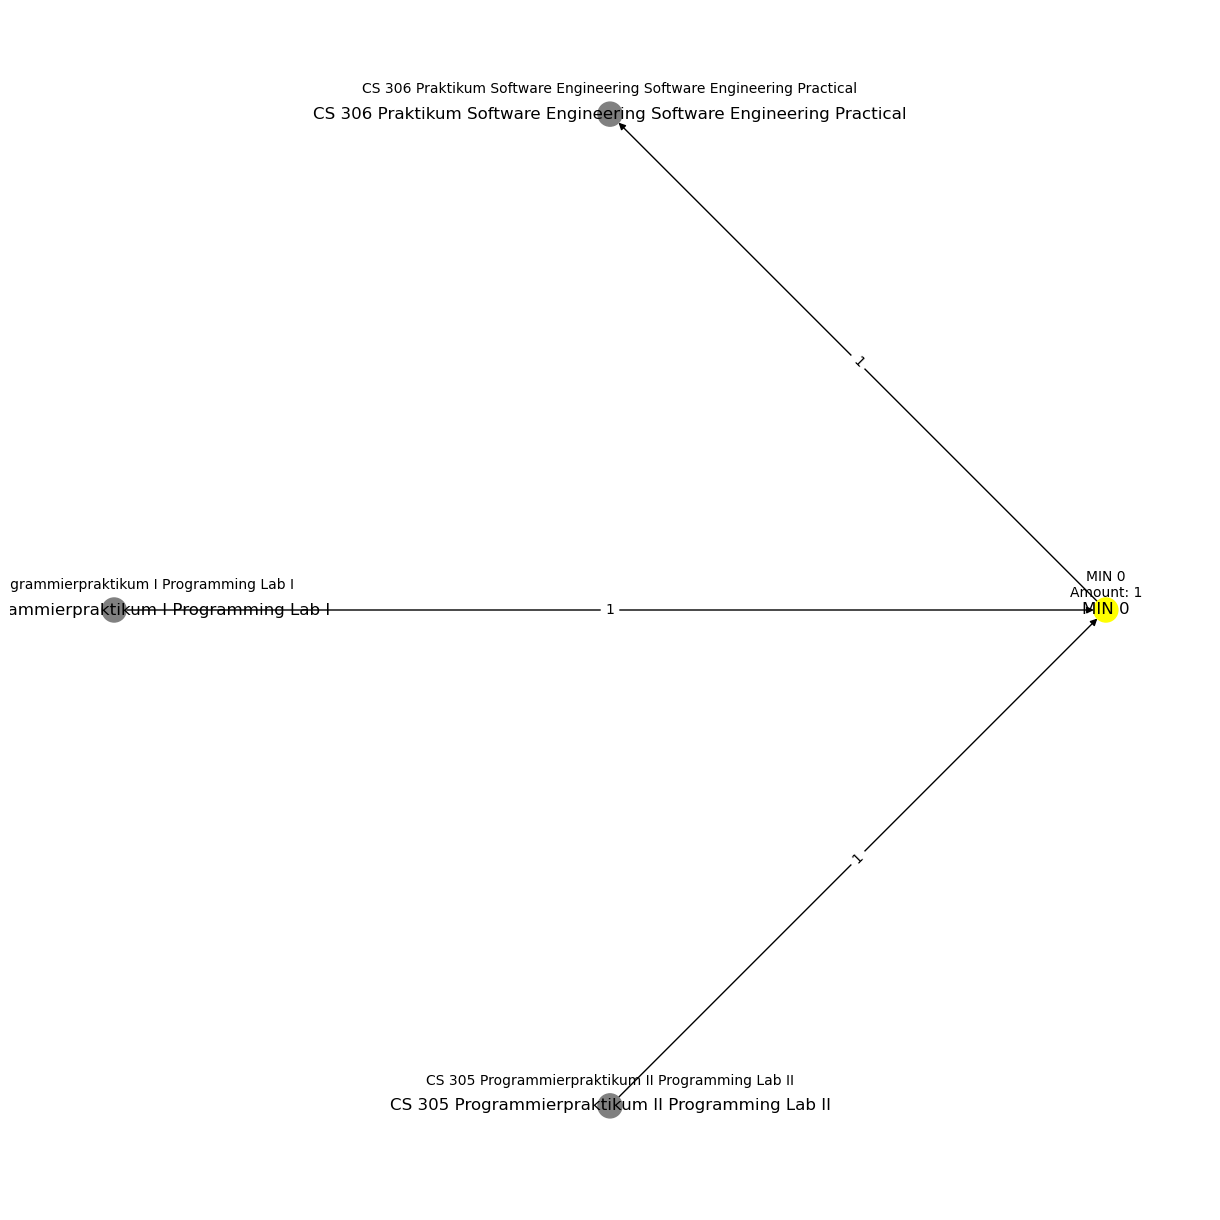

In [14]:
#Script for visualizing individual nodes

#Insert Name of the node to visualize
node_id = 'CS 306 Praktikum Software Engineering Software Engineering Practical'
node_id = 'MIN 0'
#node_id = 'SM 457 Seminar Prof. van der Aa Seminar on Process Analysis'
#node_id = "CS 308 Softwaretechnik I Software Engineering I"

#Get incoming and outgoing edges of the node
incoming_nodes = [n for n in G.predecessors(node_id) if G.nodes[n].get("type") in ["course","prerequisite"]]
outgoing_nodes = [n for n in G.successors(node_id) if G.nodes[n].get("type") in ["course","prerequisite"]]

#Uncomment the desired edges that should be included in the visualization
subgraph_nodes = set([node_id] + incoming_nodes + outgoing_nodes)
#subgraph_nodes = set([node_id] + outgoing_nodes)
#subgraph_nodes = set([node_id] + incoming_nodes)

#Create the plot
subgraph = G.subgraph(subgraph_nodes)
pos = nx.circular_layout(subgraph)
plt.figure(figsize=(12, 12))

node_colors = [subgraph.nodes[node]['color'] for node in subgraph.nodes()]
nx.draw(subgraph, pos, with_labels=True, node_color=node_colors, font_size=12)
node_labels = {
    node: f"{node}\nAmount: {subgraph.nodes[node]['amount']}" 
    if 'amount' in subgraph.nodes[node] else node
    for node in subgraph.nodes()
}

offset = 0.05 
label_pos = {node: (pos[node][0], pos[node][1] + offset) for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, label_pos, labels=node_labels, font_size=10)
edge_labels = nx.get_edge_attributes(subgraph, 'weight')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels)

plt.savefig("Outputs/Prerequisite_Visualization.pdf", format="pdf")
plt.show()

#### 2.1.3 Extraction of Key Courses
This part contains the code used to extract the key courses of the curriculum.

In [17]:
#Calculate the number and accumulated weight of the course -> skill and skill -> course edges of all course nodes

#List for skill -> course edges
incoming_skills = []
#List for course -> skill edges
outgoing_skills = []

for node in G.nodes:
    if G.nodes[node].get("type") == "course":
        incoming_edges = G.in_edges(node)
        count = 0
        weight = 0
        for edge in incoming_edges:
            if G.nodes[edge[0]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        incoming_skills.append([node, count, weight])
        
        outgoing_edges = G.out_edges(node)
        count = 0
        weight = 0
        for edge in outgoing_edges:
            if G.nodes[edge[1]].get("type") == "skill":
                count += 1
                weight += G.edges[edge].get("weight")
        outgoing_skills.append([node,count, weight])

In [31]:
#Get the courses with the highest number / accumulated weight of their course -> skill / skill -> course edges

#skill -> course edges
incoming_skills_counts = [x[1] for x in incoming_skills]
incoming_skills_weights = [x[2] for x in incoming_skills]

incoming_skills_counts_avg = sum(incoming_skills_counts) / len(incoming_skills_counts)
incoming_skills_weights_avg = sum(incoming_skills_weights) / len(incoming_skills_counts)

incoming_skills_counts_sorted = sorted(incoming_skills, key=lambda x: x[1], reverse = True)
incoming_skills_weights_sorted = sorted(incoming_skills, key=lambda x: x[2], reverse = True)

#course -> skill edges
outgoing_skills_counts = [x[1] for x in outgoing_skills]
outgoing_skills_weights = [x[2] for x in outgoing_skills]

outgoing_skills_counts_avg = sum(outgoing_skills_counts) / len(outgoing_skills_counts)
outgoing_skills_weights_avg = sum(outgoing_skills_weights) / len(outgoing_skills_counts)

outgoing_skills_counts_sorted = sorted(outgoing_skills, key=lambda x: x[1], reverse = True)
outgoing_skills_weights_sorted = sorted(outgoing_skills, key=lambda x: x[2], reverse = True)

print("Average incoming skills number: " + str(round(incoming_skills_counts_avg,3)))
print("Most incoming skills:")
for i in range(0, 5):
    print(incoming_skills_counts_sorted[i])

print("\nAverage outgoing skill number: " + str(round(outgoing_skills_counts_avg,3)))
print("Most outgoing skills:")
for i in range(0, 5):
    print(outgoing_skills_counts_sorted[i])

print("\nAverage incoming skill weight: " + str(round(incoming_skills_weights_avg,3)))
print("Highest incoming skill weights:")
for i in range(0, 5):
    print(incoming_skills_weights_sorted[i])

print("\nAverage outgoing skill weight: " + str(round(outgoing_skills_weights_avg,3)))
print("Highest outgoing skill weights:")
for i in range(0, 54):
    print(outgoing_skills_weights_sorted[i])

Average incoming skills number: 5.611
Most incoming skills:
['SM 442 Bachelorseminar Prof. Stuckenschmidt Seminar', 17, 22.51091275324891]
['SM 443 Bachelorseminar Prof. Ponzetto Seminar', 17, 24.70363809173375]
['SM 444 Bachelorseminar Prof. Bizer Seminar', 17, 0.0]
['SM 445 Bachelorseminar Prof. Gemulla Seminar', 17, 24.410215400784534]
['SM 446 Bachelorseminar Prof. Moerkotte', 17, 21.662005749450188]

Average outgoing skill number: 1.667
Most outgoing skills:
['CS 305 Programmierpraktikum II Programming Lab II', 6, 3.728356929619484]
['IS 204 Wirtschaftsinformatik IV Business Informatics IV', 5, 1.211270906113629]
['CS 303 Praktische Informatik II Practical Computer Science II', 5, 2.8807931915777]
['CS 306 Praktikum Software Engineering Software Engineering Practical', 5, 1.4250577505698523]
['CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science', 4, 4.085422564030787]

Average incoming skill weight: 7.779
Highest incoming skill weights:
['SM 443 Bachelo

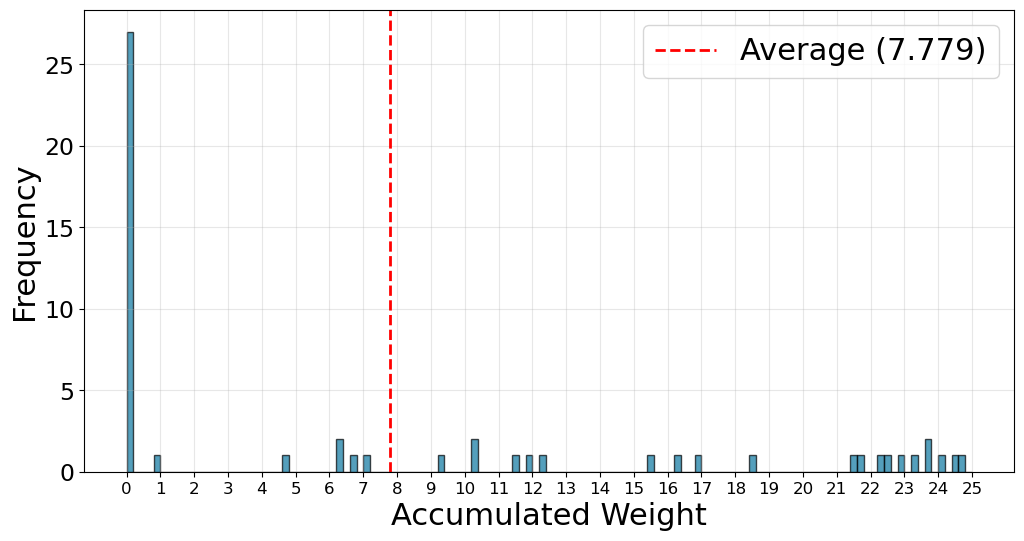

In [32]:
# Create Histogram of the distribution of the accumulated weights of all skill -> course edges

plt.figure(figsize=(12, 6))
bins = np.linspace(0, 25, 126)
counts, bin_edges, bars = plt.hist(incoming_skills_weights, bins=bins, color='#0B76A0', edgecolor='black', alpha=0.7)

# Add average
plt.axvline(incoming_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({incoming_skills_weights_avg:.3f})')

# Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
plt.xticks(np.arange(0, 26, 1), fontsize=12) 
plt.yticks(fontsize=17)
plt.grid(alpha=0.3)

# Show and export
plt.savefig('Outputs/AccumulatedIncomingSkillWeights_Bachelor.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

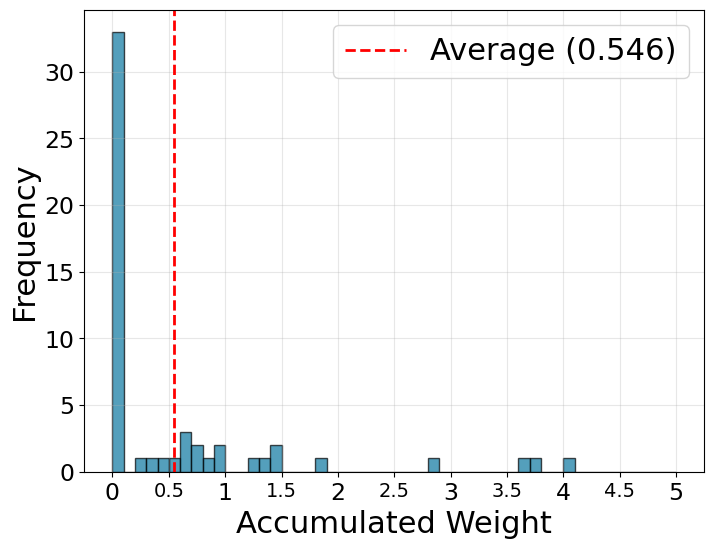

In [97]:
# Create Histogram of the distribution of the accumulated weights of all course -> skill edges

plt.figure(figsize=(8, 6))
bins = np.linspace(0, 5, 51)
counts, bin_edges, bars = plt.hist(outgoing_skills_weights, bins=bins, color='#0B76A0', edgecolor='black', alpha=0.7)

# Add average
plt.axvline(outgoing_skills_weights_avg, color='red', linestyle='dashed', linewidth=2, label=f'Average ({outgoing_skills_weights_avg:.3f})')

# Add Labels
plt.xlabel('Accumulated Weight', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
plt.legend(fontsize=22)
xticks = np.arange(0, 5.5, 0.5)
xtick_labels = []

# Set different font size for integers and floats on x-axis
for tick in xticks:
    if tick.is_integer():
        xtick_labels.append(f'{int(tick)}') 
    else:
        xtick_labels.append(f'{tick:.1f}') 
xtick_fontsizes = [17 if tick.is_integer() else 14 for tick in xticks]
plt.xticks(xticks, labels=xtick_labels)
for label, size in zip(plt.gca().get_xticklabels(), xtick_fontsizes):
    label.set_fontsize(size)

plt.yticks(fontsize=17)
plt.grid(alpha=0.3)

# Show and export
plt.savefig('Outputs/HistogramAccumulatedOutgoingEdges_Bachelor.png', format='png', dpi=300, bbox_inches='tight') 
plt.show()

### 2.2 Two-Step Course Recommendation Algorithm
#### 2.2.1 Greedy Selection & Optimization Phase
This part contains the code used to analyze the differences between the two phases of the Two-Step Course Recommendation Algorithm.

In [21]:
#Define the weight vector
default_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Generate the study plans
greedy, final, iterations = cs.twoStepAlgo(G, 32, 180, default_weights, "FWS")
course_rewards = cs.getCourseRewards(G, default_weights)

#Print both study plans together with their rewards. Normalized rewards correspond to the rewards calculated based on the default weight vector
cs.printStudyPlan(G, greedy[0], "FWS")
print("Reward: " + str(cs.getPlanReward(G, greedy[0], "FWS", course_rewards)))
cs.printStudyPlan(G, final, "FWS")
print("Reward: " + str(cs.getPlanReward(G, final, "FWS", course_rewards)))
print("Iterations: " + str(iterations))

--------------------------------------------------------------
Semester 1:
['CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science', 'CS 302 Praktische Informatik I Practical Computer Science I', 'CS 304 Programmierpraktikum I Programming Lab I', 'MAT 303 Lineare Algebra I Linear Algebra I', 'Zeitmanagement Time Management', 'Change- und Projektmanagement Projectmanagement']
ECTS: 31
Semester 2:
['CS 305 Programmierpraktikum II Programming Lab II', 'CS 303 Praktische Informatik II Practical Computer Science II', 'IS 202a Wirtschaftsinformatik IIa: Einführung in die Modellierung I: Logik Business Informatics IIa: Foundations of Modeling I: logic', 'CS 306 Praktikum Software Engineering Software Engineering Practical', 'Programmierkurs C/C++', 'IS 204 Wirtschaftsinformatik IV Business Informatics IV', 'IS 202b Wirtschaftsinformatik IIb: Einführung in die Modellierung II: Prozessmodelle Business Informatics IIb: Foundations of Modeling II: process models']
ECTS: 

In [23]:
#Analyze differences between the actual and recommended skill level for a course in context of its accumulated course -> skill edge weight

#print "Course Name: (actual skill level - recommended skill level), accumulated course -> skill edge weight"
cs.printSkillDiff(G, greedy[0], "FWS", course_rewards)
print("---------------------------------------------------")
cs.printSkillDiff(G, final, "FWS", course_rewards)

Semester: 1
CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science: 0, 4.085422564030786
CS 302 Praktische Informatik I Practical Computer Science I: 0, 3.641374912380025
CS 304 Programmierpraktikum I Programming Lab I: 0, 1.8913767551188059
MAT 303 Lineare Algebra I Linear Algebra I: 0, 0.621405091874625
Zeitmanagement Time Management: 0, 0
Change- und Projektmanagement Projectmanagement: 0, 0
Semester: 2
CS 305 Programmierpraktikum II Programming Lab II: -0.11251284264930383, 3.728356929619484
CS 303 Praktische Informatik II Practical Computer Science II: 0.0, 2.8807931915777
IS 202a Wirtschaftsinformatik IIa: Einführung in die Modellierung I: Logik Business Informatics IIa: Foundations of Modeling I: logic: 0.0, 1.3156701256070626
CS 306 Praktikum Software Engineering Software Engineering Practical: -3.0874606784707765, 1.4250577505698523
Programmierkurs C/C++: -2.5088008881419004, 0.97251975239546
IS 204 Wirtschaftsinformatik IV Business Informatics IV: -4.

#### 2.2.2 Impact of the Weight Vector
This part contains the code used to analyze the impact of the weight vector on the Two-Step Course Recommendation Algorithm.

In [35]:
#Define the weight vector
weights = [2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

#Generate the study plans
greedy, final, iterations = cs.twoStepAlgo(G, 32, 180, weights, "FWS")
course_rewards = cs.getCourseRewards(G, weights)

#Print both study plans together with their rewards. Normalized rewards correspond to the rewards calculated based on the default weight vector
cs.printStudyPlan(G, greedy[0], "FWS")
print("Reward: " + str(cs.getPlanReward(G, greedy[0], "FWS", course_rewards)))
cs.printStudyPlan(G, final, "FWS")
print("Reward: " + str(cs.getPlanReward(G, final, "FWS", course_rewards)))
print("Iterations: " + str(iterations))

--------------------------------------------------------------
Semester 1:
['CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science', 'CS 302 Praktische Informatik I Practical Computer Science I', 'CS 304 Programmierpraktikum I Programming Lab I', 'MAT 303 Lineare Algebra I Linear Algebra I', 'Zeitmanagement Time Management', 'Change- und Projektmanagement Projectmanagement']
ECTS: 31
Semester 2:
['CS 305 Programmierpraktikum II Programming Lab II', 'CS 303 Praktische Informatik II Practical Computer Science II', 'IS 202a Wirtschaftsinformatik IIa: Einführung in die Modellierung I: Logik Business Informatics IIa: Foundations of Modeling I: logic', 'CS 306 Praktikum Software Engineering Software Engineering Practical', 'Programmierkurs C/C++', 'CS 406 Theoretische Informatik Theoretical Computer Science', 'IS 202b Wirtschaftsinformatik IIb: Einführung in die Modellierung II: Prozessmodelle Business Informatics IIb: Foundations of Modeling II: process models']
EC

In [29]:
#Analyze differences between the actual and recommended skill level for a course in context of its accumulated course -> skill edge weight

#print "Course Name: (actual skill level - recommended skill level), accumulated course -> skill edge weight"
cs.printSkillDiff(G, greedy[0], "FWS", course_rewards)
print("---------------------------------------------------")
cs.printSkillDiff(G, final, "FWS", course_rewards)

Semester: 1
CS 301 Formale Grundlagen der Informatik Formal Foundations of Computer Science: 0, 6.238507512974554
CS 302 Praktische Informatik I Practical Computer Science I: 0, 8.110921080954835
CS 304 Programmierpraktikum I Programming Lab I: 0, 3.3102502960268643
MAT 303 Lineare Algebra I Linear Algebra I: 0, 0.621405091874625
Zeitmanagement Time Management: 0, 0
Change- und Projektmanagement Projectmanagement: 0, 0
Semester: 2
CS 305 Programmierpraktikum II Programming Lab II: -0.11251284264930383, 6.358842696868956
CS 303 Praktische Informatik II Practical Computer Science II: 0.0, 3.8438230695459317
IS 202a Wirtschaftsinformatik IIa: Einführung in die Modellierung I: Logik Business Informatics IIa: Foundations of Modeling I: logic: 0.0, 1.3156701256070626
CS 306 Praktikum Software Engineering Software Engineering Practical: -3.0874606784707765, 3.031537075003651
Programmierkurs C/C++: -2.5088008881419004, 1.94503950479092
CS 406 Theoretische Informatik Theoretical Computer Scienc